# PCA de importações de Santos

## Setup

### Importações

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [114]:
dict_dtypes = pd.read_pickle("datasets/aux_carga_dtypes.pkl").to_dict()

In [115]:
df = pd.read_csv("datasets/df_rus_ua_psantos.csv", decimal=",", dtype=dict_dtypes)

### Limpeza

In [116]:
df.columns

Index(['IDCarga', 'IDAtracacao', 'Origem', 'Destino', 'CDMercadoria',
       'Tipo Operação da Carga', 'Carga Geral Acondicionamento',
       'ConteinerEstado', 'Tipo Navegação', 'FlagAutorizacao', 'FlagCabotagem',
       'FlagCabotagemMovimentacao', 'FlagConteinerTamanho', 'FlagLongoCurso',
       'FlagMCOperacaoCarga', 'FlagOffshore', 'FlagTransporteViaInterioir',
       'Percurso Transporte em vias Interiores',
       'Percurso Transporte Interiores', 'STNaturezaCarga', 'STSH2', 'STSH4',
       'Natureza da Carga', 'Sentido', 'TEU', 'QTCarga', 'VLPesoCargaBruta',
       'Ano'],
      dtype='object')

In [117]:
df.drop(["IDAtracacao",
         "Destino",
         "Sentido",
         "Carga Geral Acondicionamento",
         "ConteinerEstado",
         "FlagConteinerTamanho"], axis=1, inplace=True)

In [118]:
df_1 = pd.DataFrame({"A":[1, 2, 2, 3], "B": ["V", "E", "F", "G"]})
df_2 = pd.DataFrame({"A":[1, 1, 1, 3], "C": ["A", "B", "C", "D"]})

In [119]:
df_3 = df_1.merge(df_2, on="A", how="left")
df_3

,A,B,C
0,1,V,A
1,1,V,B
2,1,V,C
3,2,E,NaN
4,2,F,NaN
5,3,G,D


In [120]:
df_4 = df_3.copy()
df_4["B"] = df_3["C"].combine_first(df_3["B"])
df_4

,A,B,C
0,1,A,A
1,1,B,B
2,1,C,C
3,2,E,NaN
4,2,F,NaN
5,3,D,D


In [142]:
df_1 = pd.DataFrame({"A": ["A", "1", "B"], "B": [3, 4, 5]})
df_1

,A,B
0,A,3
1,1,4
2,B,5


In [150]:
portos_cats = df_mestre["Origem"].astype("category")

In [159]:
lista_cats = list(portos_cats.cat.categories[-3:]) + list(portos_cats.cat.categories[:-3])

### Junção de Carga com Carga Conteinerizada

In [121]:
df_mestre = df.copy()
for ano in range(df["Ano"].min(), df["Ano"].max() + 1):
    print("Ano atual: ", ano)
    df_cont = pd.read_csv(f"/home/vortex/Documents/Fatec/Trabalhos/Projeto Integrador local/BD/ANTAQ/{ano}Carga_Conteinerizada.csv", sep=";", decimal=",", dtype=dict_dtypes)

    df_mestre = df_mestre.merge(df_cont,"left", "IDCarga", suffixes=('', '_x'))

    # Combinação
    df_mestre["VLPesoCargaBruta"] = df_mestre["VLPesoCargaConteinerizada"].combine_first(df_mestre["VLPesoCargaBruta"])
    df_mestre.drop("VLPesoCargaConteinerizada", axis=1, inplace=True)
    df_mestre["CDMercadoria"] = df_mestre["CDMercadoriaConteinerizada"].combine_first(df_mestre["CDMercadoria"])
    df_mestre.drop("CDMercadoriaConteinerizada", axis=1, inplace=True)

del df_cont
del df

Ano atual:  2018
Ano atual:  2019
Ano atual:  2020
Ano atual:  2021
Ano atual:  2022
Ano atual:  2023


### Categorização

In [123]:
df_cat = df_mestre.copy()

In [124]:
for col in df_cat:
    if df_cat[col].dtype == "category":
        df_cat[col] = df_cat[col].cat.codes
    if df_cat[col].dtype == "object":
        df_cat[col] = df_cat[col].astype("category").cat.codes

In [125]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10786 entries, 0 to 10785
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   IDCarga                                 10786 non-null  int64  
 1   Origem                                  10786 non-null  int8   
 2   CDMercadoria                            10786 non-null  int16  
 3   Tipo Operação da Carga                  10786 non-null  int8   
 4   Tipo Navegação                          10786 non-null  int8   
 5   FlagAutorizacao                         10786 non-null  int8   
 6   FlagCabotagem                           10786 non-null  boolean
 7   FlagCabotagemMovimentacao               10786 non-null  boolean
 8   FlagLongoCurso                          10786 non-null  boolean
 9   FlagMCOperacaoCarga                     10786 non-null  boolean
 10  FlagOffshore                            10786 non-null  bo

In [126]:
df_cat.drop("IDCarga",axis=1, inplace=True)

In [127]:
df_cat = df_cat.fillna(0)

### Normalização dos dados

In [128]:
normalizador = StandardScaler()

In [129]:
arr_cat_norm = normalizador.fit_transform(df_cat)

## PCA

### Estimador e projeção

In [130]:
pca = PCA()

In [131]:
df_proj = pd.DataFrame(pca.fit_transform(arr_cat_norm), columns=pca.get_feature_names_out())

### Influência nas colunas do PCA

In [132]:
df_comp = pd.DataFrame(pca.components_, pca.get_feature_names_out(), df_cat.columns)

Maior influência em pca0

In [133]:
df_comp.abs().sort_values(by="pca0", axis=1, ascending=False).head(3)

,STSH2,STNaturezaCarga,STSH4,Natureza da Carga,Ano,CDMercadoria,TEU,VLPesoCargaBruta,QTCarga,Origem,...,FlagAutorizacao,Tipo Navegação,FlagCabotagem,FlagCabotagemMovimentacao,FlagLongoCurso,FlagTransporteViaInterioir,FlagOffshore,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,FlagMCOperacaoCarga
pca0,0.580254,0.530797,0.435039,0.257764,0.186454,0.182060,0.157777,0.152406,0.069506,0.065539,...,1.110223e-16,1.110223e-16,1.387779e-17,3.469447e-18,2.168404e-19,1.058791e-22,0.000000e+00,0.0,0.0,0.0
pca1,0.189347,0.231810,0.345830,0.524772,0.386371,0.289719,0.312052,0.341616,0.057854,0.235593,...,0.000000e+00,8.326673e-17,0.000000e+00,3.469447e-18,4.336809e-19,0.000000e+00,6.776264e-21,0.0,0.0,0.0
pca2,0.018262,0.038800,0.009335,0.086298,0.131169,0.312710,0.526616,0.176182,0.448656,0.506008,...,1.110223e-16,0.000000e+00,0.000000e+00,2.775558e-17,6.938894e-18,0.000000e+00,1.734723e-18,0.0,0.0,0.0


Maior influência em pca1

In [134]:
df_comp.abs().sort_values(by="pca1", axis=1, ascending=False).head(2)

,Natureza da Carga,Ano,STSH4,VLPesoCargaBruta,TEU,CDMercadoria,Origem,STNaturezaCarga,STSH2,Tipo Operação da Carga,...,Tipo Navegação,FlagCabotagemMovimentacao,FlagLongoCurso,FlagOffshore,FlagMCOperacaoCarga,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,FlagCabotagem,FlagAutorizacao,FlagTransporteViaInterioir
pca0,0.257764,0.186454,0.435039,0.152406,0.157777,0.182060,0.065539,0.530797,0.580254,0.026464,...,1.110223e-16,3.469447e-18,2.168404e-19,0.000000e+00,0.0,0.0,0.0,1.387779e-17,1.110223e-16,1.058791e-22
pca1,0.524772,0.386371,0.345830,0.341616,0.312052,0.289719,0.235593,0.231810,0.189347,0.096327,...,8.326673e-17,3.469447e-18,4.336809e-19,6.776264e-21,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00


## Plotagem

In [137]:
df_mestre["Natureza da Carga"].unique().tolist()

['Granel Sólido',
 'Carga Conteinerizada',
 'Carga Geral',
 'Granel Líquido e Gasoso']

In [138]:
x_col = "Natureza da Carga"

In [139]:
x_estilos = {
    'Granel Sólido': ('#1f77b4', 'o'),
    'Carga Conteinerizada': ('#ff7f0e', 's'),
    'Carga Geral': ('#2ca02c', 'v'),
    'Granel Líquido e Gasoso': ('#d62728', '^')
}

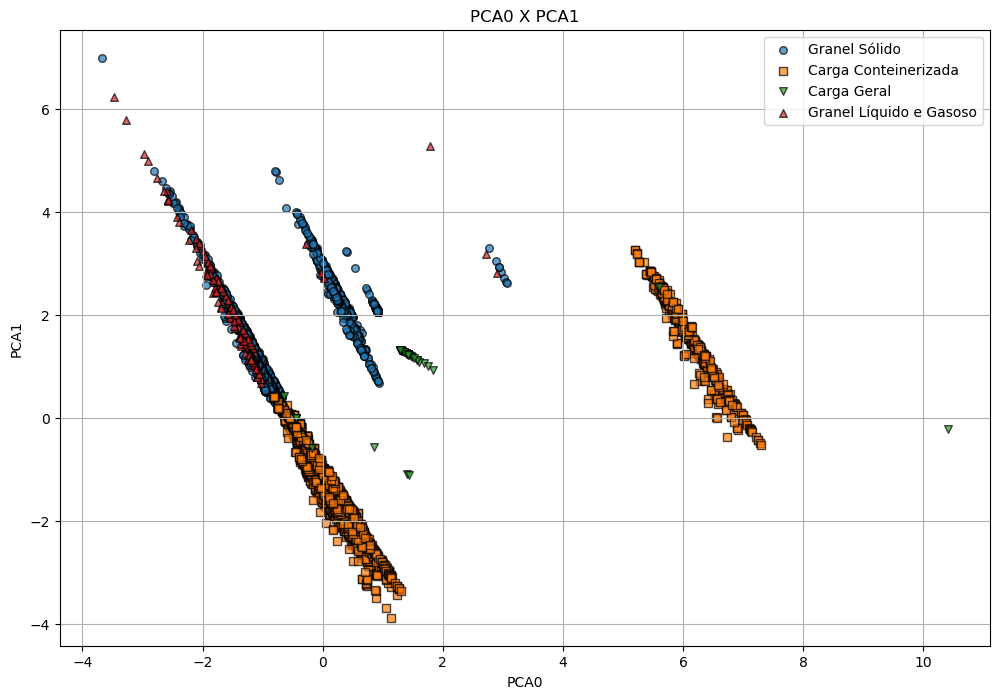

In [140]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend()
plt.show()

Relação com ano e tipo de carga?